In [2]:
import omicverse as ov
# import scvelo as scv
import matplotlib.pyplot as plt
ov.ov_plot_set()
import scanpy as sc

ModuleNotFoundError: No module named 'omicverse'

In [1]:
adata = sc.read("../h5ad/myeloid_BP2_unintegrated_annotated2.h5ad")
adata

NameError: name 'sc' is not defined

In [ ]:
# Convert 'Sex' and 'Disease.State' to strings and then concatenate them
adata.obs['celltype_disease'] = adata.obs['celltype'].astype(str) + "_" + adata.obs['disease'].astype(str)

In [ ]:
adata = adata[adata.obs['celltype'].isin(['Classical'])]

In [ ]:
# Define the fraction of cells you want to subsample (e.g., 0.5 for 50%)
fraction_to_subsample = 0.5

# Randomly subsample the AnnData object
adata = adata[adata.obs.sample(frac=fraction_to_subsample).index]

In [5]:
ov.utils.store_layers(adata,layers='counts')
adata

......The X of adata have been stored in counts


AnnData object with n_obs × n_vars = 31201 × 1887
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'unintegrated_clusters', 'seurat_clusters', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'celltypes.disease', 'celltypes.prog', 'celltypes.disease.state', 'celltype', 'ident', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Disease_CellType', 'celltype_disease'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'X_name', 'layers_counts'
    obsm: 'pca', 'umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=2000)

Begin robust gene identification
After filtration, 1887/1887 genes are kept. Among 1887 genes, 1887 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [7]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 31201 × 1887
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'unintegrated_clusters', 'seurat_clusters', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'celltypes.disease', 'celltypes.prog', 'celltypes.disease.state', 'celltype', 'ident', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Disease_CellType', 'celltype_disease'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'X_name', 'layers_counts', 'log1p', 'hvg'
    obsm: 'pca', 'umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [8]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm["X_mde_pca"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

In [9]:
adata=adata.raw.to_adata()

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>

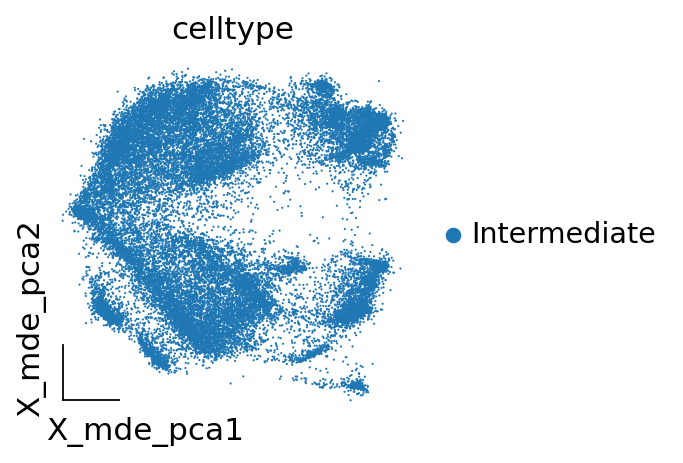

In [10]:
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['celltype'],show=False,ax=ax)

In [11]:
adata.obs['celltype_disease']

GEM1_AAACGCTGTGTTGAGG-1    Intermediate_HC
GEM1_AAAGAACTCTGTGCAA-1    Intermediate_HC
GEM1_AAAGGATTCGCGTGCA-1    Intermediate_HC
GEM1_AAAGGGCAGCTCATAC-1    Intermediate_HC
GEM1_AAAGGGCAGTTCTCTT-1    Intermediate_HC
                                ...       
GEM9_TTTGGAGAGTCCCTAA-1    Intermediate_HC
GEM9_TTTGGAGCAGCGAGTA-1    Intermediate_HC
GEM9_TTTGGAGTCGATACTG-1    Intermediate_HC
GEM9_TTTGGTTAGTTTCGAC-1    Intermediate_HC
GEM9_TTTGTTGTCGCCGATG-1    Intermediate_HC
Name: celltype_disease, Length: 31201, dtype: category
Categories (2, object): ['Intermediate_HC', 'Intermediate_MS']

In [13]:
import SEACells
# adata=adata[adata.obs['clusters']!='Endothelial']
model = SEACells.core.SEACells(adata, 
                  build_kernel_on='scaled|original|X_pca', 
                  n_SEACells=200, 
                  n_waypoint_eigs=10,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [14]:
model.construct_kernel_matrix()
M = model.kernel_matrix
# Initialize archetypes
model.initialize_archetypes()

Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/31201 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/31201 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/31201 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on scaled|original|X_pca
Computing diffusion components from scaled|original|X_pca for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
Done.
Sampling waypoints ...
Done.
Selecting 191 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 38.40it/s]

Selecting 9 cells from greedy initialization.


In [15]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00336
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 29 iterations.


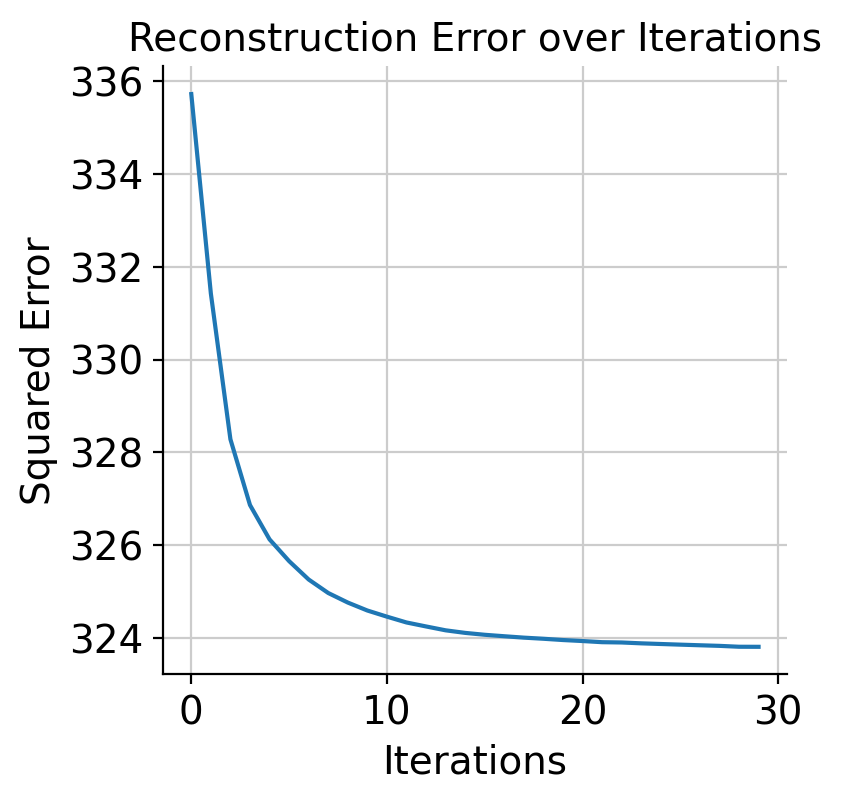

In [16]:
# Check for convergence 
%matplotlib inline
model.plot_convergence()

In [17]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Run for {len(model.RSS_iters)} iterations')
for _ in range(10):
    model.step()
print(f'Run for {len(model.RSS_iters)} iterations')

Run for 30 iterations
Run for 40 iterations


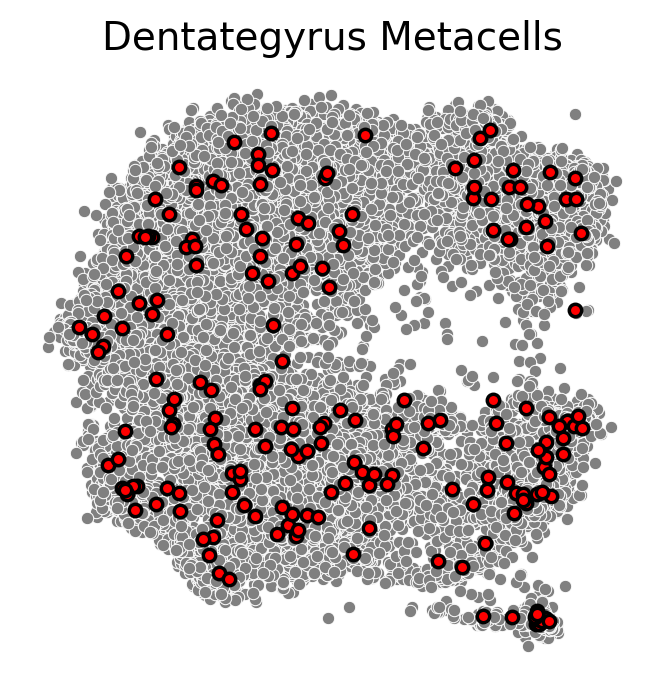

In [18]:
%matplotlib inline
SEACells.plot.plot_2D(adata, key='X_mde_pca', colour_metacells=False,
                     figsize=(4,4),cell_size=20,title='Dentategyrus Metacells',
                     )

In [19]:
adata.raw=adata.copy()

In [21]:
adata.write("intermediate_mono_postTraining.h5ad")

In [24]:
import pickle

In [25]:
with open('intermediate_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [27]:
adata

AnnData object with n_obs × n_vars = 31201 × 1887
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'unintegrated_clusters', 'seurat_clusters', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'celltypes.disease', 'celltypes.prog', 'celltypes.disease.state', 'celltype', 'ident', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Disease_CellType', 'celltype_disease', 'SEACell'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'X_name', 'layers_counts', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'neighbors'
    obsm: 'pca', 'umap', 'scaled|original|X_pca', 'X_mde_pca'
    obsp: 'distances', 'connectivities'

In [20]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(adata, model.A_, 
                                                          celltype_label='celltype_disease',
                                                          summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

  0%|                                                                                                         | 0/200 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'multiply'

In [ ]:
import scanpy as sc
SEACell_soft_ad.raw=SEACell_soft_ad.copy()
sc.pp.highly_variable_genes(SEACell_soft_ad, n_top_genes=2000, inplace=True)
SEACell_soft_ad=SEACell_soft_ad[:,SEACell_soft_ad.var.highly_variable]

In [ ]:
ov.pp.scale(SEACell_soft_ad)
ov.pp.pca(SEACell_soft_ad,layer='scaled',n_pcs=50)
sc.pp.neighbors(SEACell_soft_ad, use_rep='scaled|original|X_pca')
sc.tl.umap(SEACell_soft_ad)

In [ ]:
SEACell_soft_ad.obs['celltype']=SEACell_soft_ad.obs['celltype'].astype('category')
# SEACell_soft_ad.obs['celltype']=SEACell_soft_ad.obs['celltype'].cat.reorder_categories(adata.obs['clusters'].cat.categories)
# SEACell_soft_ad.uns['celltype_colors']=adata.uns['clusters_colors']

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(SEACell_soft_ad,
                   basis='X_umap',
                   color=["celltype_disease"],
                   title='Meta Celltype',
                   frameon='small',
                   legend_fontsize=12,
                   #palette=ov.utils.palette()[11:],
                   ax=ax,
                   show=False)

In [ ]:
v0 = ov.single.pyVIA(adata=SEACell_soft_ad,adata_key='scaled|original|X_pca',
                         adata_ncomps=50, basis='X_umap',
                         clusters='celltype_disease',knn=10, root_user=['Intermediate_HC'],
                         dataset='group', 
                         random_seed=112,is_coarse=True, 
                         preserve_disconnected=True,
                         piegraph_arrow_head_width=0.05,piegraph_edgeweight_scalingfactor=2.5,
                         gene_matrix=SEACell_soft_ad.X,velo_weight=0.5,
                         edgebundle_pruning_twice=False, edgebundle_pruning=0.15, 
                         jac_std_global=0.05,too_big_factor=0.05,
                         cluster_graph_pruning_std=1,
                         time_series=False,
                        )

v0.run()

In [ ]:
v0.get_pseudotime(SEACell_soft_ad)

In [ ]:
#v0.get_pseudotime(SEACell_soft_ad)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(SEACell_soft_ad,
                   basis='X_umap',
                   color=["pt_via"],
                   title='Pseudotime',
                   frameon='small',
                   cmap='Reds',
                   #size=40,
                   legend_fontsize=12,
                   #palette=ov.utils.palette()[11:],
                   ax=ax,
                   show=False)

In [ ]:
cfg_obj=ov.single.cellfategenie(SEACell_soft_ad,pseudotime='pt_via')
cfg_obj.model_init()

In [ ]:
cfg_obj.ATR(stop=500,flux=0.01)

In [ ]:
fig,ax=cfg_obj.plot_filtering(color='#5ca8dc')
ax.set_title('Dentategyrus Metacells\nCellFateGenie')

In [ ]:
res=cfg_obj.model_fit()

In [ ]:
cfg_obj.plot_color_fitting(type='filter',cluster_key='celltype_disease')

In [ ]:
kt_filter=cfg_obj.kendalltau_filter()
kt_filter.head()

In [ ]:
var_name=kt_filter.loc[kt_filter['pvalue']